In [8]:
# Team Bravo

# Tiange Chang, Chen Liu, Zihao Li, Qingluo Xu, Haoxuan Zhang

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from arch.unitroot import ADF
from statsmodels.tsa import stattools
from statsmodels.tsa import arima_model
import math
from statsmodels.graphics.tsaplots import *
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from scipy import stats

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from arch.unitroot import ADF
from statsmodels.tsa import stattools
from statsmodels.tsa import arima_model
import math
from statsmodels.graphics.tsaplots import *
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from scipy import stats

# Summary Stats

In [75]:
data = pd.read_csv('angels_market.csv')

In [76]:
data.head()

,vendorID,theme,homeState,carnivals,complaints,est_energy,est_hourly_vol,LL_passholder,est_hourly_gross
0,1,Hot Chocolate/Warm Treats,Maine,3,9,57.291961,118,0,217.93
1,2,Local Artists,Vermont,1,2,39.404898,105,1,209.51
2,3,Fortune Teller,New Hampshire,5,4,47.175958,94,0,200.68
3,4,Fried Dough and Pizza,Maine,8,0,58.192568,118,0,251.40
4,5,craft beer,New Hampshire,7,6,56.657908,102,0,168.76


From data.head we noticed a colomn called complaints. This conponent illustrates "the number of complaints received against that vendor during previous appearances either at carnivals or at carnival-type events".

In [77]:
hs_g = data.groupby('homeState').sum(numeric_only=True)[['complaints']]
hs_g['Total Complaints'] = hs_g['complaints']
hs_g.pop('complaints')
hs_g

,Total Complaints
homeState,
2,8
4,2
5,20
6,6
7,12
Connecticut,267
Maine,2060
Massachusetts,197
New Hampshire,314


So I chose "complaints" as the starting point to learn the number of complaints in different "homestates". 
Among them, Maine is nearly ten times higher than other states.

In [78]:
hs_g['Theme Counts'] = data.groupby('homeState').count()[['vendorID']]
hs_g['Average Complaints'] = hs_g['Total Complaints'] / hs_g['Theme Counts']
hs_g

,Total Complaints,Theme Counts,Average Complaints
homeState,,,
2,8,1,8.000000
4,2,1,2.000000
5,20,3,6.666667
6,6,1,6.000000
7,12,2,6.000000
Connecticut,267,48,5.562500
Maine,2060,417,4.940048
Massachusetts,197,27,7.296296
New Hampshire,314,70,4.485714


In [79]:
hs_g['Gross'] = data.groupby('homeState').sum(numeric_only=True)['est_hourly_gross']
hs_g['Average Gross'] = hs_g['Gross'] / hs_g['Theme Counts']

According to above table, we can clearly see a higer number of complaints does not indicate a lower gross. This is actually counter-intuitive.

In [80]:
data.corr()

,vendorID,carnivals,complaints,est_energy,est_hourly_vol,LL_passholder,est_hourly_gross
vendorID,1.000000,0.000841,-0.031996,0.104100,0.102822,-0.001489,0.122673
carnivals,0.000841,1.000000,-0.010116,-0.017299,-0.056430,0.007395,-0.063846
complaints,-0.031996,-0.010116,1.000000,-0.041120,0.018022,0.001507,-0.058058
est_energy,0.104100,-0.017299,-0.041120,1.000000,0.212523,-0.086355,0.171829
est_hourly_vol,0.102822,-0.056430,0.018022,0.212523,1.000000,-0.133518,0.587368
LL_passholder,-0.001489,0.007395,0.001507,-0.086355,-0.133518,1.000000,-0.080736
est_hourly_gross,0.122673,-0.063846,-0.058058,0.171829,0.587368,-0.080736,1.000000


According to above table, we can found correlation between est_energy and est_hourly_gross is relatively high. And I think this is intutive that a park with more vistors will take more energy.

In [15]:
# Segmantation & Targeting
mf = pd.read_csv('maine_families.csv')
mf.head()

,householdID,total_ppl,own_rent,square_foot,household_income,number_pets,region,entertainment_spend_est,travel_spend_est,LL_passholder
0,1,1.0,own,3309,82050.03,1,Aroostook,3189.11,2028.559211,Yes
1,2,1.0,own,3814,83077.81,2,Midcoast,4175.35,4713.280000,Yes
2,3,2.0,rent,2592,91401.41,2,Downeast_Acadia,1814.98,3479.070000,No
3,4,1.0,own,2628,73048.55,1,Greater Portland,1945.14,3842.420000,No
4,5,1.0,rent,2442,89145.36,2,Kennebec Valley,4410.86,1913.280000,Yes


In [16]:
mf.describe()

,householdID,total_ppl,square_foot,household_income,number_pets,entertainment_spend_est,travel_spend_est
count,15000.000000,14925.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7500.500000,1.580570,3118.928600,84660.356712,1.509200,3451.933114,3682.613712
std,4330.271354,0.815143,815.925967,25754.657878,0.790163,1228.454404,908.453505
min,1.000000,0.000000,370.000000,1081.330000,0.000000,9.430000,1002.085526
25%,3750.750000,1.000000,2506.000000,66787.702500,1.000000,2593.902500,2972.521908
50%,7500.500000,2.000000,3042.000000,84303.245000,2.000000,3390.650000,3728.575000
75%,11250.250000,2.000000,3738.000000,102643.917500,2.000000,4279.240000,4356.152500
max,15000.000000,4.000000,6081.000000,171989.560000,4.000000,7942.620000,7014.070000


In [17]:
mf.isnull().sum()

householdID                 0
total_ppl                  75
own_rent                    0
square_foot                 0
household_income            0
number_pets                 0
region                      0
entertainment_spend_est     0
travel_spend_est            0
LL_passholder               0
dtype: int64

In [18]:
mf2 = mf.fillna(0) # Replace NA with 0, we assume NA menas 0 people live in the building. 
mf2.isnull().sum()

householdID                0
total_ppl                  0
own_rent                   0
square_foot                0
household_income           0
number_pets                0
region                     0
entertainment_spend_est    0
travel_spend_est           0
LL_passholder              0
dtype: int64

In [19]:
# Converting categorical variables to 1 and 0
# mf3 = mf2
# mf3['own_rent'] = mf3['own_rent'].map({'own': 1, 'rent': 0}) # change own to 1, rent to 0
# mf3.head()

# mf4 = mf3 # change yes to 1, no to 0; Lobsterland pass
# mf4['LL_passholder'] = mf4['LL_passholder'].map({'Yes': 1, 'No': 0})
# mf4.head()

In [20]:
mf2.head()

,householdID,total_ppl,own_rent,square_foot,household_income,number_pets,region,entertainment_spend_est,travel_spend_est,LL_passholder
0,1,1.0,own,3309,82050.03,1,Aroostook,3189.11,2028.559211,Yes
1,2,1.0,own,3814,83077.81,2,Midcoast,4175.35,4713.280000,Yes
2,3,2.0,rent,2592,91401.41,2,Downeast_Acadia,1814.98,3479.070000,No
3,4,1.0,own,2628,73048.55,1,Greater Portland,1945.14,3842.420000,No
4,5,1.0,rent,2442,89145.36,2,Kennebec Valley,4410.86,1913.280000,Yes


In [21]:
mf2.describe()

,householdID,total_ppl,square_foot,household_income,number_pets,entertainment_spend_est,travel_spend_est
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7500.500000,1.572667,3118.928600,84660.356712,1.509200,3451.933114,3682.613712
std,4330.271354,0.820710,815.925967,25754.657878,0.790163,1228.454404,908.453505
min,1.000000,0.000000,370.000000,1081.330000,0.000000,9.430000,1002.085526
25%,3750.750000,1.000000,2506.000000,66787.702500,1.000000,2593.902500,2972.521908
50%,7500.500000,2.000000,3042.000000,84303.245000,2.000000,3390.650000,3728.575000
75%,11250.250000,2.000000,3738.000000,102643.917500,2.000000,4279.240000,4356.152500
max,15000.000000,4.000000,6081.000000,171989.560000,4.000000,7942.620000,7014.070000


In [22]:
mf_num = mf2[['total_ppl', 'square_foot', 'household_income', 'number_pets', 'entertainment_spend_est', 'travel_spend_est']]
mf_num.head()

,total_ppl,square_foot,household_income,number_pets,entertainment_spend_est,travel_spend_est
0,1.0,3309,82050.03,1,3189.11,2028.559211
1,1.0,3814,83077.81,2,4175.35,4713.280000
2,2.0,2592,91401.41,2,1814.98,3479.070000
3,1.0,2628,73048.55,1,1945.14,3842.420000
4,1.0,2442,89145.36,2,4410.86,1913.280000


In [23]:
zscore = preprocessing.StandardScaler()
mf_standard = zscore.fit_transform(mf_num)
mf_standard = pd.DataFrame(mf_standard)
mf_standard.columns = mf_num.columns
round(mf_standard.describe(), 2)

,total_ppl,square_foot,household_income,number_pets,entertainment_spend_est,travel_spend_est
count,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00
mean,0.00,-0.00,0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.92,-3.37,-3.25,-1.91,-2.80,-2.95
25%,-0.70,-0.75,-0.69,-0.64,-0.70,-0.78
50%,0.52,-0.09,-0.01,0.62,-0.05,0.05
75%,0.52,0.76,0.70,0.62,0.67,0.74
max,2.96,3.63,3.39,3.15,3.66,3.67


In [24]:
mf_standard.head()

,total_ppl,square_foot,household_income,number_pets,entertainment_spend_est,travel_spend_est
0,-0.697793,0.232960,-0.101357,-0.644446,-0.213953,-1.820797
1,-0.697793,0.851909,-0.061449,0.621159,0.588903,1.134566
2,0.520705,-0.645826,0.261750,0.621159,-1.332575,-0.224063
3,-0.697793,-0.601703,-0.450877,-0.644446,-1.226617,0.175916
4,-0.697793,-0.829672,0.174149,0.621159,0.780622,-1.947698


<AxesSubplot:title={'center':'The Elbow Method'}, xlabel='k', ylabel='SSE'>

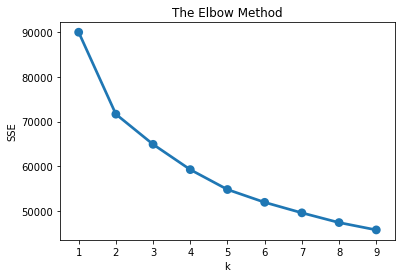

In [25]:
# Elbow chart
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(mf_standard)
    sse[k] = kmeans.inertia_
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x = list(sse.keys()), y = list(sse.values()))

In [26]:
# k-means
kmeans = KMeans(n_clusters = 4, random_state = 0)
kmeans.fit(mf_standard)
cluster_labels = kmeans.labels_

MF_standard = mf_standard.assign(Cluster = cluster_labels)
MF_standard.groupby(['Cluster']).agg({
    'total_ppl': 'mean',
    'square_foot': 'mean',
    'household_income': 'mean',
    'number_pets': 'mean',
    'entertainment_spend_est': 'mean',
    'travel_spend_est': 'mean'
}).round(2)

,total_ppl,square_foot,household_income,number_pets,entertainment_spend_est,travel_spend_est
Cluster,,,,,,
0,0.28,-0.74,-0.56,-0.01,-0.46,-0.88
1,-1.12,-0.08,0.41,-0.06,0.22,0.46
2,0.50,0.11,0.99,0.01,1.10,0.75
3,0.37,0.94,-0.58,0.07,-0.61,-0.01


In [27]:
kmeans = KMeans(n_clusters = 6, random_state = 0)
kmeans.fit(mf_standard)
cluster_labels = kmeans.labels_

MF_standard = mf_standard.assign(Cluster = cluster_labels)
MF_standard.groupby(['Cluster']).agg({
    'total_ppl': 'mean',
    'square_foot': 'mean',
    'household_income': 'mean',
    'number_pets': 'mean',
    'entertainment_spend_est': 'mean',
    'travel_spend_est': 'mean'
}).round(2)

,total_ppl,square_foot,household_income,number_pets,entertainment_spend_est,travel_spend_est
Cluster,,,,,,
0,0.24,-0.63,-0.58,-0.90,-0.46,-0.77
1,0.41,1.12,-0.58,-0.02,-0.63,0.06
2,0.29,-0.57,-0.55,0.90,-0.46,-0.79
3,-0.94,0.01,0.51,0.94,0.35,0.55
4,0.75,0.11,1.00,-0.08,1.12,0.74
5,-1.00,0.03,0.52,-0.93,0.36,0.54


In [28]:
kmeans = KMeans(n_clusters = 5, random_state = 0)
kmeans.fit(mf_standard)
cluster_labels = kmeans.labels_

MF_standard = mf_standard.assign(Cluster = cluster_labels)
MF_standard.groupby(['Cluster']).agg({
    'total_ppl': 'mean',
    'square_foot': 'mean',
    'household_income': 'mean',
    'number_pets': 'mean',
    'entertainment_spend_est': 'mean',
    'travel_spend_est': 'mean'
}).round(2)

,total_ppl,square_foot,household_income,number_pets,entertainment_spend_est,travel_spend_est
Cluster,,,,,,
0,0.24,-0.56,-0.54,-0.94,-0.44,-0.70
1,0.53,0.16,1.04,-0.03,1.16,0.78
2,0.26,1.18,-0.48,0.00,-0.55,0.15
3,-1.16,-0.12,0.52,-0.03,0.31,0.54
4,0.27,-0.53,-0.50,0.95,-0.43,-0.70


By using the Elbow Method, I want to choose my k-value between 4-6. After trying all three clusterings, I decided to use 5 as my k-value. The naming is below. 

In [29]:
MF = mf2.assign(Cluster = cluster_labels)
MF.dtypes

householdID                  int64
total_ppl                  float64
own_rent                    object
square_foot                  int64
household_income           float64
number_pets                  int64
region                      object
entertainment_spend_est    float64
travel_spend_est           float64
LL_passholder               object
Cluster                      int32
dtype: object

In [30]:
MF['Cluster'] = MF['Cluster'].astype('category')
MF['Cluster'] = MF['Cluster'].cat.rename_categories({0: 'Saving money', 1: 'I am rich', 
                                                     2: 'I am old', 3: 'I love to travel', 4: 'I love pets'})
MF['Cluster'].dtype

CategoricalDtype(categories=['Saving money', 'I am rich', 'I am old', 'I love to travel',
                  'I love pets'],
, ordered=False)

In [31]:
MF.head()

,householdID,total_ppl,own_rent,square_foot,household_income,number_pets,region,entertainment_spend_est,travel_spend_est,LL_passholder,Cluster
0,1,1.0,own,3309,82050.03,1,Aroostook,3189.11,2028.559211,Yes,Saving money
1,2,1.0,own,3814,83077.81,2,Midcoast,4175.35,4713.280000,Yes,I love to travel
2,3,2.0,rent,2592,91401.41,2,Downeast_Acadia,1814.98,3479.070000,No,I love pets
3,4,1.0,own,2628,73048.55,1,Greater Portland,1945.14,3842.420000,No,Saving money
4,5,1.0,rent,2442,89145.36,2,Kennebec Valley,4410.86,1913.280000,Yes,I love pets


In [32]:
MF_standard['Cluster'] = MF_standard['Cluster'].astype('category')
MF_standard['Cluster'] = MF_standard['Cluster'].cat.rename_categories({0: 'Saving money', 1: 'I am rich', 
                                                                       2: 'I am old', 3: 'I love to travel', 4: 'I love pets'})
MF_standard['Cluster'].dtype

CategoricalDtype(categories=['Saving money', 'I am rich', 'I am old', 'I love to travel',
                  'I love pets'],
, ordered=False)

In [33]:
MF_standard.head()

,total_ppl,square_foot,household_income,number_pets,entertainment_spend_est,travel_spend_est,Cluster
0,-0.697793,0.232960,-0.101357,-0.644446,-0.213953,-1.820797,Saving money
1,-0.697793,0.851909,-0.061449,0.621159,0.588903,1.134566,I love to travel
2,0.520705,-0.645826,0.261750,0.621159,-1.332575,-0.224063,I love pets
3,-0.697793,-0.601703,-0.450877,-0.644446,-1.226617,0.175916,Saving money
4,-0.697793,-0.829672,0.174149,0.621159,0.780622,-1.947698,I love pets


Naming

Saving money: I name this cluster saving money because they live in the smallest house, have the lowest income, almost do not have pets, and have the lowest budget for both entertainment and travel. 

I am rich: I name this cluster I am rich because they have the highest income, entertainment spend, and travel spent. 

I am old: I name this cluster I am old because they live in the largest house but have a second lowest income. They do not like entertainment but would like to spend some money on travel. 

I love to travel: I name this cluster I love to travel because the total number of people in the house are low, and their travel spent is second highest, so they might be all out for traveling!

I love pets: I name this cluster I love pets because they have the most pets!

<AxesSubplot:title={'center':'Mean numbers of pets per cluster member'}, xlabel='number_pets', ylabel='Cluster'>

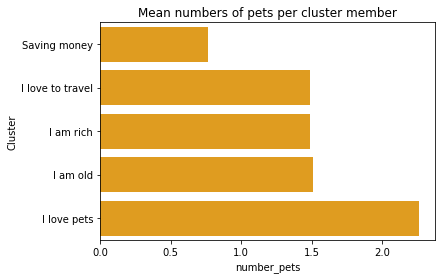

In [34]:
order = MF.groupby(['Cluster'])['number_pets'].mean().sort_values().index
plt.title('Mean numbers of pets per cluster member')
sns.barplot(y = 'Cluster', x = 'number_pets', ci = None, order = order, color = 'orange', data = MF)

<AxesSubplot:title={'center':'Mean numbers of entertainment spend per cluster member'}, xlabel='entertainment_spend_est', ylabel='Cluster'>

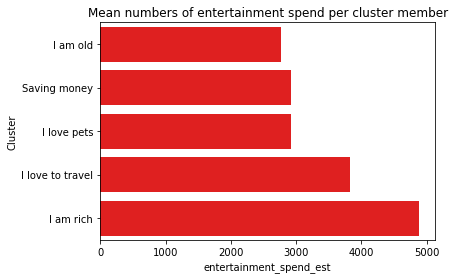

In [35]:
order = MF.groupby(['Cluster'])['entertainment_spend_est'].mean().sort_values().index
plt.title('Mean numbers of entertainment spend per cluster member')
sns.barplot(y = 'Cluster', x = 'entertainment_spend_est', ci = None, order = order, color = 'red', data = MF)

In [36]:
discretionary = MF.groupby('Cluster')[['entertainment_spend_est', 'travel_spend_est']].mean()
discretionary

,entertainment_spend_est,travel_spend_est
Cluster,,
Saving money,2916.006195,3042.656331
I am rich,4882.596554,4390.713615
I am old,2771.008371,3820.344648
I love to travel,3831.952374,4170.382650
I love pets,2923.625453,3044.197535


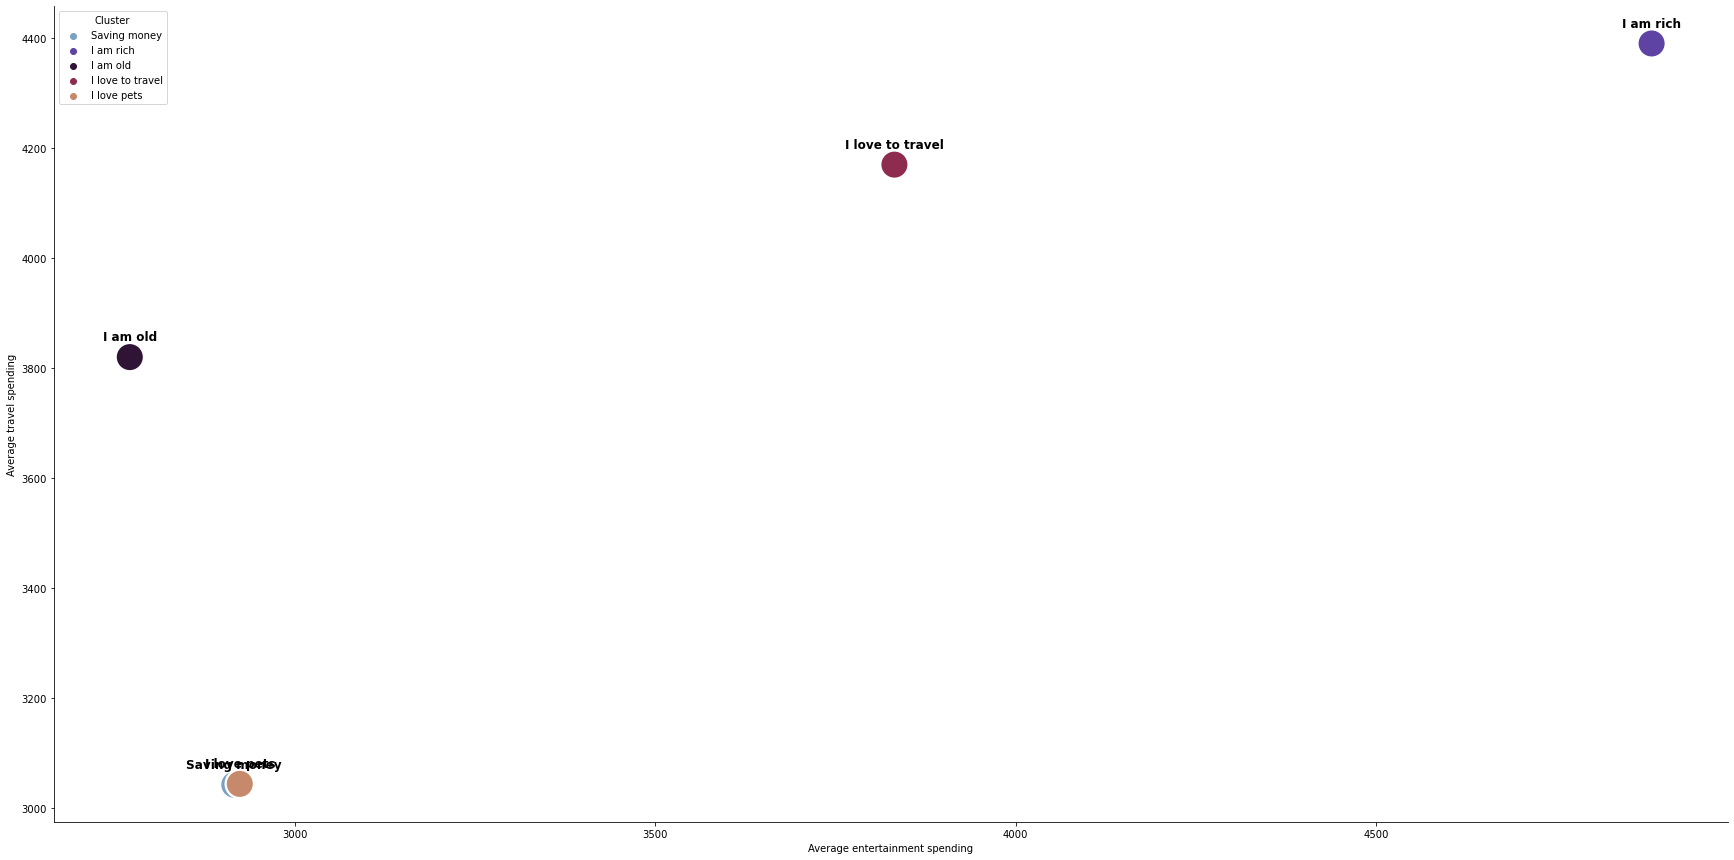

In [37]:
plt.figure(figsize = (30,15))
plt.xlabel('Average entertainment spending')
plt.ylabel('Average travel spending')
sns.despine()

p1 = sns.scatterplot(x = 'entertainment_spend_est', y = 'travel_spend_est', s = 800, hue = 'Cluster', palette = 'twilight', data = discretionary)

for line in range(0, discretionary.shape[0]): 
    p1.text(discretionary.entertainment_spend_est[line], 
            discretionary.travel_spend_est[line] + 30,
            discretionary.index[line], 
            horizontalalignment = 'center',
            size = 'large', 
            color = 'black', 
            weight = 'semibold')

<AxesSubplot:ylabel='Cluster'>

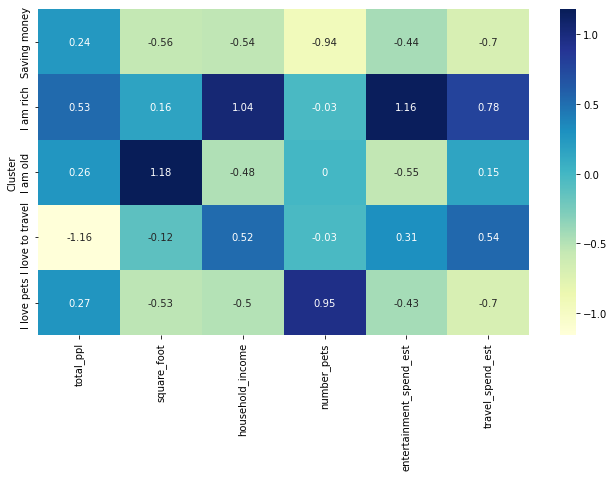

In [38]:
summary = MF_standard.groupby(['Cluster']).agg({
    'total_ppl': 'mean',
    'square_foot': 'mean',
    'household_income': 'mean',
    'number_pets': 'mean',
    'entertainment_spend_est': 'mean',
    'travel_spend_est': 'mean'
}). round(2)

plt.figure(figsize = (11, 6))
sns.heatmap(summary, annot = True, cmap = 'YlGnBu', fmt = 'g')

In [39]:
# entertainment spending falls above the dataset mean 
entertainment_fans = MF[(MF['Cluster'] == 'I am rich') | (MF['Cluster'] == 'I love to travel')]
entertainment_fans.Cluster.value_counts()

I love to travel    3248
I am rich           2771
Saving money           0
I am old               0
I love pets            0
Name: Cluster, dtype: int64

<AxesSubplot:xlabel='household_income', ylabel='Cluster'>

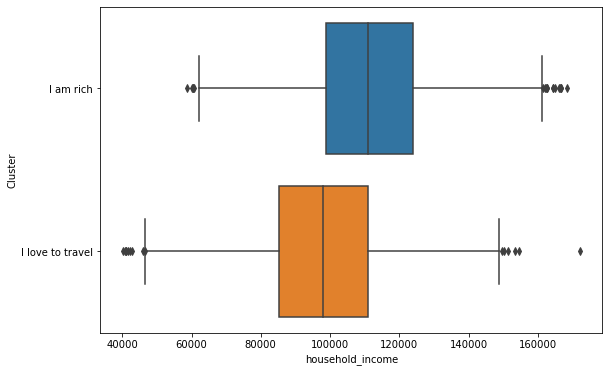

In [40]:
# boxplot
plt.figure(figsize = (9, 6))
order2 = ['I am rich', 'I love to travel']
sns.boxplot(y = 'Cluster', x = 'household_income', order = order2, data = entertainment_fans)

<AxesSubplot:xlabel='LL_passholder', ylabel='count'>

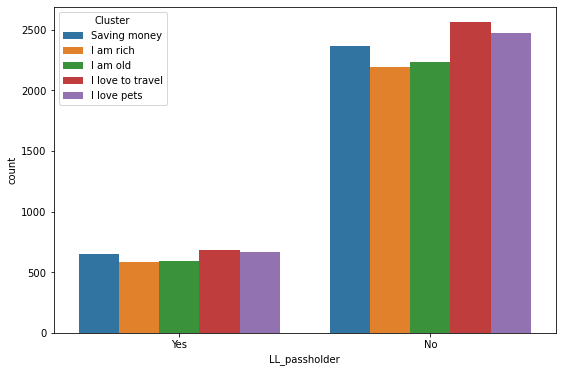

In [41]:
plt.figure(figsize = (9, 6))
sns.countplot(x = 'LL_passholder', hue = 'Cluster', data = MF)

<AxesSubplot:xlabel='region', ylabel='count'>

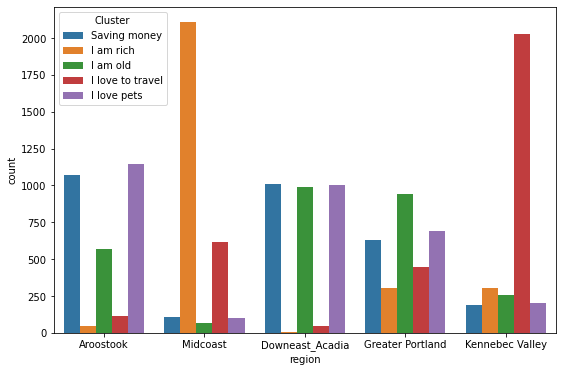

In [42]:
plt.figure(figsize = (9, 6))
sns.countplot(x = 'region', hue = 'Cluster', data = MF)

Targeting

Saving money: Since they are on a budget, in order to reach this segment we can send them coupons. They are probably students, and we can cooperate with Unidays to send out promotions. 

I am rich: They have enough budgets, we just need to let them know our place. We can let celebrities advertise the Lobster Land. We can also sell premium ticks to them, the premium tickets could have features such as shorter wait time, free lobster, etc...

I am old: We could lunch senior tickets at a lower price, and advertise the Lobster Land in newspapers instead of the internet. 

I love to travel: Because they love traveling, they might have travel credit cards that provide travel points, instead of cash back. Therefore, we can cooperate with the bank, so they can use their travel points for ticket purchasing. 

I love pets: We can build some pet-friendly areas, and provide pet food. Advertise the lobster land on pet-related companies such as Petco. 

In [43]:
# Conjoint Analysis
df_1 = pd.read_csv('bbq_lake.csv')
df_2 = pd.read_csv('vendor_costs.csv')

In [44]:
display(df_1.head(),
        df_2)

,bundleID,starter,maindishI,maindishII,side,dessert,avg_rating
0,1,Fried Chicken Tenders,BBQ Brisket,Sausage,Mac and Cheese,Peach Cobbler,5.81
1,2,Fried Chicken Tenders,BBQ Brisket,Sausage,Mac and Cheese,Apple Pie a la Mode,8.93
2,3,Fried Chicken Tenders,BBQ Brisket,Sausage,Mashed Potato,Peach Cobbler,6.20
3,4,Fried Chicken Tenders,BBQ Brisket,Sausage,Mashed Potato,Apple Pie a la Mode,8.71
4,5,Fried Chicken Tenders,BBQ Brisket,Sausage,French Fry Platter,Peach Cobbler,8.24


,Item,Item Category,Cost Per Serving (Dollars)
0,Fried Chicken Tenders,Starters,3.40
1,Crabcakes and Shrimp,Starters,3.50
2,Sticky Chicken Tenders,Starters,2.90
3,Jumbo Shrimp,Starters,4.60
4,BBQ Brisket,Main Dish I,5.70
5,Pulled Pork,Main Dish I,6.00
6,BBQ Chicken,Main Dish I,5.30
7,Pork & Brisket Combo,Main Dish I,6.10
8,Sausage,Main Dish II,5.30
9,Fajita,Main Dish II,4.70


In [45]:
# replace some miss-spell value, find through iteration
df_1 = df_1.replace(['French Fry Platter', 'Beef Short Rib', 'Pork and Brisket Combo', 'Jumbo Shrimp Cocktail'], ['French Fry Basket', 'Beef Short Ribs', 'Pork & Brisket Combo', 'Jumbo Shrimp'])

In [46]:
df_1 = df_1.drop('bundleID', axis = 1)  # drop bundleId for further analysis

Add total price column to df_1

In [47]:
# Put item and price to a hashtable
price_dict = df_2.set_index("Item")['Cost Per Serving (Dollars)'].to_dict()
price_dict

{'Fried Chicken Tenders': 3.4,
 'Crabcakes and Shrimp': 3.5,
 'Sticky Chicken Tenders': 2.9,
 'Jumbo Shrimp': 4.6,
 'BBQ Brisket': 5.7,
 'Pulled Pork': 6.0,
 'BBQ Chicken': 5.3,
 'Pork & Brisket Combo': 6.1,
 'Sausage': 5.3,
 'Fajita': 4.7,
 'Beef Short Ribs': 6.0,
 'Steak Sampler': 4.7,
 'Mac and Cheese': 0.25,
 'Mashed Potato': 0.1,
 'French Fry Basket': 0.15,
 'Peach Cobbler': 0.6,
 'Apple Pie a la Mode': 0.9}

In [48]:
total_price = []

In [49]:
for index, row in df_1.loc[:, df_1.columns != 'avg_rating'].iterrows():
        meal_price = 0
        for food in row:
                meal_price += price_dict[food]
        total_price.append(round(meal_price,2))
print(total_price)

[15.25, 15.55, 15.1, 15.4, 15.15, 15.45, 14.65, 14.95, 14.5, 14.8, 14.55, 14.85, 15.95, 16.25, 15.8, 16.1, 15.85, 16.15, 14.65, 14.95, 14.5, 14.8, 14.55, 14.85, 15.55, 15.85, 15.4, 15.7, 15.45, 15.75, 14.95, 15.25, 14.8, 15.1, 14.85, 15.15, 16.25, 16.55, 16.1, 16.4, 16.15, 16.45, 14.95, 15.25, 14.8, 15.1, 14.85, 15.15, 14.85, 15.15, 14.7, 15.0, 14.75, 15.05, 14.25, 14.55, 14.1, 14.4, 14.15, 14.45, 15.55, 15.85, 15.4, 15.7, 15.45, 15.75, 14.25, 14.55, 14.1, 14.4, 14.15, 14.45, 15.65, 15.95, 15.5, 15.8, 15.55, 15.85, 15.05, 15.35, 14.9, 15.2, 14.95, 15.25, 16.35, 16.65, 16.2, 16.5, 16.25, 16.55, 15.05, 15.35, 14.9, 15.2, 14.95, 15.25, 15.35, 15.65, 15.2, 15.5, 15.25, 15.55, 14.75, 15.05, 14.6, 14.9, 14.65, 14.95, 16.05, 16.35, 15.9, 16.2, 15.95, 16.25, 14.75, 15.05, 14.6, 14.9, 14.65, 14.95, 15.65, 15.95, 15.5, 15.8, 15.55, 15.85, 15.05, 15.35, 14.9, 15.2, 14.95, 15.25, 16.35, 16.65, 16.2, 16.5, 16.25, 16.55, 15.05, 15.35, 14.9, 15.2, 14.95, 15.25, 14.95, 15.25, 14.8, 15.1, 14.85, 15.15,

In [50]:
df_price = pd.DataFrame({'total_price': total_price})
df_1 = pd.concat([df_1, df_price], axis = 1)
df_1[['avg_rating','total_price']].corr()  # good which means there are no correlation between price and rating

,avg_rating,total_price
avg_rating,1.000000,0.078314
total_price,0.078314,1.000000


In [51]:
# Create dummy variables and drop_first for preventing the multicollinearity
df_default = pd.get_dummies(df_1, drop_first=True, columns=['starter','maindishI','maindishII','side','dessert'])

In [52]:
df_reference = pd.get_dummies(df_1, columns=['starter','maindishI','maindishII','side','dessert'])

In [53]:
df_default.columns

Index(['avg_rating', 'total_price', 'starter_Fried Chicken Tenders',
       'starter_Jumbo Shrimp', 'starter_Sticky Chicken Tenders',
       'maindishI_BBQ Chicken', 'maindishI_Pork & Brisket Combo',
       'maindishI_Pulled Pork', 'maindishII_Fajita', 'maindishII_Sausage',
       'maindishII_Steak Sampler', 'side_Mac and Cheese', 'side_Mashed Potato',
       'dessert_Peach Cobbler'],
      dtype='object')

In [54]:
df_reference.columns

Index(['avg_rating', 'total_price', 'starter_Crabcakes and Shrimp',
       'starter_Fried Chicken Tenders', 'starter_Jumbo Shrimp',
       'starter_Sticky Chicken Tenders', 'maindishI_BBQ Brisket',
       'maindishI_BBQ Chicken', 'maindishI_Pork & Brisket Combo',
       'maindishI_Pulled Pork', 'maindishII_Beef Short Ribs',
       'maindishII_Fajita', 'maindishII_Sausage', 'maindishII_Steak Sampler',
       'side_French Fry Basket', 'side_Mac and Cheese', 'side_Mashed Potato',
       'dessert_Apple Pie a la Mode', 'dessert_Peach Cobbler'],
      dtype='object')

In [55]:
X = df_default.loc[:, ~df_default.columns.isin(['avg_rating', 'total_price'])]
Y = df_default['avg_rating']
regressor =LinearRegression()
regressor.fit(X, Y)

LinearRegression()

In [56]:
co_ef = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])

In [57]:
X_2 = df_reference.loc[:, ['starter_Crabcakes and Shrimp',
       'starter_Fried Chicken Tenders', 'starter_Jumbo Shrimp',
       'maindishI_BBQ Brisket',
       'maindishI_BBQ Chicken', 'maindishI_Pork & Brisket Combo',
        'maindishII_Beef Short Ribs',
       'maindishII_Fajita', 'maindishII_Sausage',
       'side_French Fry Basket', 'side_Mac and Cheese',
       'dessert_Apple Pie a la Mode']]
Y_2 = df_reference['avg_rating']
regressor_2 =LinearRegression()
regressor_2.fit(X_2, Y_2)

LinearRegression()

In [58]:
co_ef_ref = pd.DataFrame(regressor_2.coef_, X_2.columns, columns=['Coefficient'])
display(co_ef,
        co_ef_ref)

,Coefficient
starter_Fried Chicken Tenders,0.103854
starter_Jumbo Shrimp,-0.451771
starter_Sticky Chicken Tenders,0.093333
maindishI_BBQ Chicken,-0.207917
maindishI_Pork & Brisket Combo,1.063646
maindishI_Pulled Pork,0.577188
maindishII_Fajita,-0.498313
maindishII_Sausage,0.342917
maindishII_Steak Sampler,0.232813
side_Mac and Cheese,0.419688


,Coefficient
starter_Crabcakes and Shrimp,-0.093333
starter_Fried Chicken Tenders,0.010521
starter_Jumbo Shrimp,-0.545104
maindishI_BBQ Brisket,-0.577188
maindishI_BBQ Chicken,-0.785104
maindishI_Pork & Brisket Combo,0.486458
maindishII_Beef Short Ribs,-0.232812
maindishII_Fajita,-0.731125
maindishII_Sausage,0.110104
side_French Fry Basket,0.002500


In [59]:
df_1.loc[df_1['avg_rating'].idxmax(), :]

starter        Fried Chicken Tenders
maindishI       Pork & Brisket Combo
maindishII           Beef Short Ribs
side               French Fry Basket
dessert          Apple Pie a la Mode
avg_rating                      9.97
total_price                    16.55
Name: 89, dtype: object

15.466666666666663


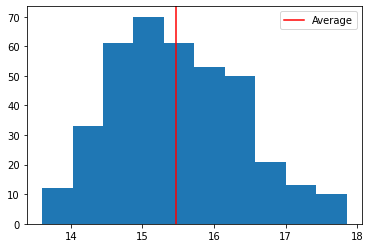

<Figure size 2160x1296 with 0 Axes>

In [60]:
plt.hist(df_1['total_price'])
plt.axvline(sum(df_1['total_price']/ len(df_1)), color = 'red', label = 'Average')
plt.legend()
plt.figure(figsize=(30,18))
print(sum(df_1['total_price']/ len(df_1)))

In [61]:
df_profit = df_1[df_1['total_price'] < 15]
df_profit.loc[df_profit['avg_rating'].idxmax(), :]

starter        Sticky Chicken Tenders
maindishI                 BBQ Chicken
maindishII              Steak Sampler
side                   Mac and Cheese
dessert           Apple Pie a la Mode
avg_rating                       9.97
total_price                     14.05
Name: 259, dtype: object

In [62]:
# Forecasting Total Revenue

<AxesSubplot:xlabel='year'>

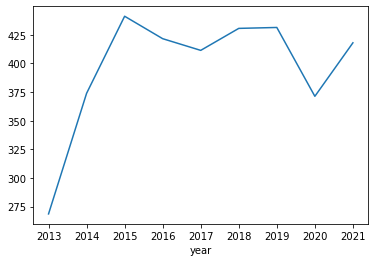

In [7]:
TSM=pd.read_csv('data.csv',index_col='year')
TSM['revenue'].plot()

In [8]:
TSM.head(3)

,revenue
year,
2013,268.6
2014,373.9
2015,441.2


In [9]:
TSM.tail(3)

,revenue
year,
2019,431.4
2020,371.3
2021,418.0


In [10]:
ADF(TSM['revenue']).summary()

Test Statistic,-4.741
P-value,0.000
Lags,0


In [11]:
stattools.q_stat(stattools.acf(TSM['revenue']),len(data['revenue']))[1][-1]

0.0

In [12]:
stattools.arma_order_select_ic(TSM['revenue'],max_ma=4)

{'bic':             0           1           2           3           4
 0  100.626466  100.484028  102.674069  103.802583  105.344296
 1  102.146341  102.677719  107.109002  105.818097  107.973081
 2  103.094100  104.975705  107.189322  109.276561  109.703737
 3  104.948094  108.335886  107.577644  109.493850  115.988367
 4         NaN  109.356616  108.955703  111.611856         NaN,
 'bic_min_order': (0, 1)}

In [13]:
model=arima_model.ARIMA(TSM['revenue'],order=(0,0,1)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.29448D+00    |proj g|=  7.92697D-02

At iterate    5    f=  5.21728D+00    |proj g|=  1.35056D-03

At iterate   10    f=  5.21626D+00    |proj g|=  3.66818D-05

At iterate   15    f=  5.21624D+00    |proj g|=  1.42109D-06

At iterate   20    f=  5.21624D+00    |proj g|=  4.44089D-07

At iterate   25    f=  5.21624D+00    |proj g|=  1.77636D-07
  ys= 0.000E+00  -gs= 1.140E-10 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Proj

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                revenue   No. Observations:                    9
Model:                     ARMA(0, 1)   Log Likelihood                 -46.946
Method:                       css-mle   S.D. of innovations             39.234
Date:                Tue, 13 Dec 2022   AIC                             99.892
Time:                        22:02:25   BIC                            100.484
Sample:                             0   HQIC                            98.616
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           394.1207     24.810     15.886      0.000     345.495     442.747
ma.L1.revenue     0.9997      0.551      1.815      0.070      -0.080       2.079
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.0003           +0.0000j            1.0003            0.5000
-----------------------------------------------------------------------------
"""

In [15]:
model.conf_int()

,0,1
const,345.494526,442.746948
ma.L1.revenue,-0.080050,2.079414


In [16]:
stdresid=model.resid/math.sqrt(model.sigma2)

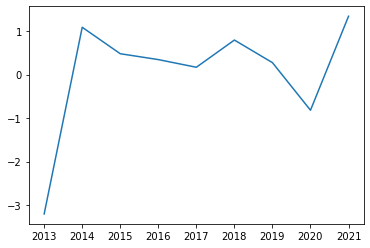

In [17]:
plt.plot(stdresid)

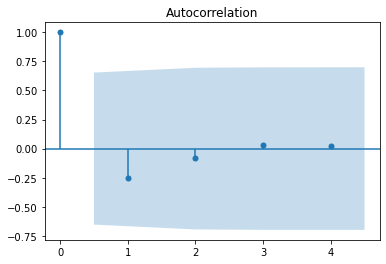

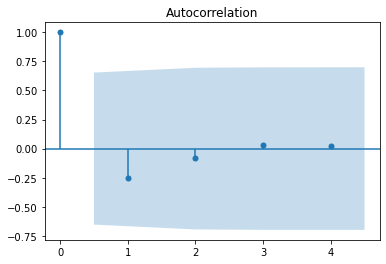

In [18]:
plot_acf(stdresid,lags=4)

In [19]:
revenue2022=round(model.forecast(1)[0][0],2)
print("forecast 2022 revenue:",revenue2022)

forecast 2022 revenue: 446.57


In [20]:
TSM.loc['2022']=revenue2022

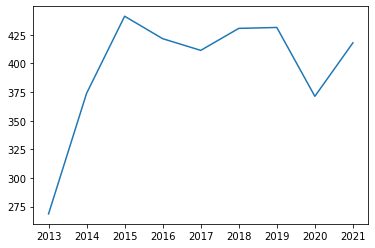

In [21]:
plt.plot(data['revenue'])

Firstly, We collected data from  Town Square Media's financial statements and obtained it's revenue data for the last 9 years and then make an annual income graph. It can be seen from the graph that the growth has been rapid from 2013 to 2015, but it has declined since 2015, rebounded since 2017, then rose and fell, but it began to decline from 2019, reached the bottom in 2020, and then rebounded from 2020 to 2021.

Secondly we add a adf test and we find that the p value is less than 0.05,we can reject the null hypothesis,so it is a stationary data. From the ljungbox and the q_stat we can see that the data is not a white noise,so we can build a time series predict on this data.

Thirdly we use the auto select arima method,we find that the best model is arima(0,0,1),and then build a arima(0,0,1) model,and we can find that the residuals have not obvious auto_correlation.

At the last,we use the model to predict the 2022 year revenue is $446.57 million,and we plot the total revenue with the year from 2013 to 2022,we can find the predict value continued the continuous growth since 2021.


In [42]:
# Classification method: Random forest model
visitors = pd.read_csv("carnival_visitors.csv")
visitors.head()

,householdID,est_inc_USD,est_netw_USD,hhold_field,hhold_oldest,hhold_pax,hhold_youngest,homeState,hhold_car,stream_subs,primary
0,23,59245,381931,Govt,48,2,8,New York,SUV,2,0
1,27,116628,457159,Tech,51,5,21,New Hampshire,SUV,3,1
2,36,65835,394803,Services,50,4,13,Vermont,Pickup,3,0
3,41,132483,429296,Tech,54,2,11,Massachusetts,SUV,3,1
4,44,83444,488210,Education,51,7,12,Maine,SUV,3,0


In this part,We believe that “est_netw_USD” duplicates the functionality of “est_inc_USD” and that “hhold_car” would be less helpful to predict whether a particular household’s primary goal for attending a music festival will be “consume” or “entertain”.

So,we will use following variables to build the model: est_inc_USD, hhold_field, hhold_oldest, hhold_pax, hhold_youngest, homeState, stream_subs, primary

In [43]:
visitors.describe()

,householdID,est_inc_USD,est_netw_USD,hhold_oldest,hhold_pax,hhold_youngest,stream_subs,primary
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7500.500000,94350.965000,466169.094800,45.327400,4.458933,14.984133,3.990933,0.541600
std,4330.271354,27826.069636,71050.877531,4.966017,1.796106,8.361085,1.746383,0.498283
min,1.000000,-2537.000000,180540.000000,25.000000,1.000000,1.000000,0.000000,0.000000
25%,3750.750000,75246.750000,418090.500000,42.000000,3.000000,11.000000,3.000000,0.000000
50%,7500.500000,93209.500000,466061.000000,45.000000,4.000000,13.000000,4.000000,1.000000
75%,11250.250000,113346.250000,514245.250000,49.000000,6.000000,16.000000,5.000000,1.000000
max,15000.000000,204057.000000,774358.000000,66.000000,12.000000,62.000000,11.000000,1.000000


In [44]:
# Dummify the categorical inputs
visitors2 = pd.get_dummies(visitors, columns=['hhold_field', 'homeState'])
visitors2.head()

,householdID,est_inc_USD,est_netw_USD,hhold_oldest,hhold_pax,hhold_youngest,hhold_car,stream_subs,primary,hhold_field_Education,...,homeState_Connecticut,homeState_Maine,homeState_Massachusetts,homeState_New Hampshire,homeState_New York,homeState_Ontario,homeState_Quebec,homeState_Rhode Island,homeState_US_Other,homeState_Vermont
0,23,59245,381931,48,2,8,SUV,2,0,0,...,0,0,0,0,1,0,0,0,0,0
1,27,116628,457159,51,5,21,SUV,3,1,0,...,0,0,0,1,0,0,0,0,0,0
2,36,65835,394803,50,4,13,Pickup,3,0,0,...,0,0,0,0,0,0,0,0,0,1
3,41,132483,429296,54,2,11,SUV,3,1,0,...,0,0,1,0,0,0,0,0,0,0
4,44,83444,488210,51,7,12,SUV,3,0,1,...,0,1,0,0,0,0,0,0,0,0


In [45]:
visitors2.columns

Index(['householdID', 'est_inc_USD', 'est_netw_USD', 'hhold_oldest',
       'hhold_pax', 'hhold_youngest', 'hhold_car', 'stream_subs', 'primary',
       'hhold_field_Education', 'hhold_field_Finance', 'hhold_field_Govt',
       'hhold_field_Manufacturing', 'hhold_field_Other',
       'hhold_field_Services', 'hhold_field_Tech', 'homeState_Can_Other',
       'homeState_Connecticut', 'homeState_Maine', 'homeState_Massachusetts',
       'homeState_New Hampshire', 'homeState_New York', 'homeState_Ontario',
       'homeState_Quebec', 'homeState_Rhode Island', 'homeState_US_Other',
       'homeState_Vermont'],
      dtype='object')

In [46]:
# Create a data partition
X = visitors2[['est_inc_USD', 'hhold_oldest', 'hhold_pax', 'hhold_youngest',
               'stream_subs', 'hhold_field_Education', 'hhold_field_Finance', 
               'hhold_field_Govt','hhold_field_Manufacturing', 'hhold_field_Other',
               'hhold_field_Services', 'hhold_field_Tech', 'homeState_Can_Other',
               'homeState_Connecticut', 'homeState_Maine', 'homeState_Massachusetts',
               'homeState_New Hampshire', 'homeState_New York', 'homeState_Ontario',
               'homeState_Quebec', 'homeState_Rhode Island', 'homeState_US_Other',
               'homeState_Vermont']]
y = visitors2['primary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1000)
X_train.shape

(9000, 23)

In [47]:
# Determine optimal hyperparameters
clf=RandomForestClassifier()
clf.fit(X_train,y_train)

RandomForestClassifier()

In [48]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 8, 10, 12],
    'max_features': [12, 16, 20],
    'min_samples_leaf': [6, 10, 14],
}

In [49]:
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)

{'max_depth': 10, 'max_features': 12, 'min_samples_leaf': 14, 'n_estimators': 150}


In [50]:
# Build a random forest model
clf=RandomForestClassifier(n_estimators=150, max_depth=8, max_features=20, min_samples_leaf=14, random_state=1000)
clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=8, max_features=20, min_samples_leaf=14,
                       n_estimators=150, random_state=1000)

In [51]:
# View accuracy rate of the model
predictions = clf.predict(X_test)
print("Accuracy:",accuracy_score(y_test, predictions))

Accuracy: 0.7163333333333334


The accuracy rate of the model is 71.63%.

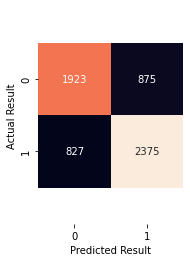

In [52]:
# Build a confusion matrix
predictions = clf.predict(X_test)
mat = confusion_matrix(y_test, predictions)
sns.heatmap(mat, fmt='g', square=True, annot=True, cbar=False)
plt.xlabel("Predicted Result")
plt.ylabel("Actual Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b)
plt.show()

In [53]:
# See if the model is well-built for new data
print("Accuracy of training set:",metrics.accuracy_score(y_train, clf.predict(X_train)))
print("Accuracy of test set:",metrics.accuracy_score(y_test, clf.predict(X_test)))

Accuracy of training set: 0.7431111111111111
Accuracy of test set: 0.7163333333333334


The model’s accuracy or training set is 0.74, while its accuracy of test set is 0.72. The two numbers are very close, meaning that the model is well-built for new data.

In [54]:
# View a table of feature importances
feature_imp_df = pd.DataFrame(list(zip(clf.feature_importances_, X_train)))
feature_imp_df.columns = ['feature importance', 'feature']
feature_imp_df = feature_imp_df.sort_values(by='feature importance', ascending=False)
feature_imp_df

,feature importance,feature
1,0.301588,hhold_oldest
4,0.237846,stream_subs
0,0.109417,est_inc_USD
3,0.092681,hhold_youngest
10,0.067554,hhold_field_Services
5,0.060764,hhold_field_Education
2,0.040497,hhold_pax
7,0.035400,hhold_field_Govt
6,0.017577,hhold_field_Finance
11,0.012895,hhold_field_Tech


In [55]:
#The predicted probability for each household choosing “consume” or “entertain”  
clf.predict_proba(X_test)

array([[0.14856122, 0.85143878],
       [0.39461066, 0.60538934],
       [0.41709268, 0.58290732],
       ...,
       [0.18290187, 0.81709813],
       [0.91158472, 0.08841528],
       [0.30381587, 0.69618413]])

**Conclusion of the model**

In the random forest model, we can find that the three most importance variables in order are “hhold_oldest”, “stream_subs” and “est_inc_USD”, while all the dummy variables of “homeState” are least important. Based on this finding, we could pay more attention to analyze the age, entertainment service subscriptions and household income. Moreover, we can remove the “homeState” variable if we need to update the model later. This will help the park to reduce the data collection costs.

For marketing approaches, Lobster Land could apply the outcomes for customer acquisition and targeting. If the festival intends to concentrate on live perfoduirmances, the resort's marketing division should place a strong emphasis on promotions to attract the households that the model anticipates are more engaged in entertainment. If the event intends to emphasize eating and retail, the marketing division should place greater emphasis on luring families that the model predicts would be more interested in consuming.

Lobster Land may also utilize the algorithm to boost survey feedback return rates. Only households that enjoy watching shows could get the entertainment survey since they are more likely to respond. Similar for a different class. Based on a review of the input, the park may provide more well-liked live events or cuisine in this instance.

Additionally, Lobster Land could also pay attention to the predict_proba() results. The resort should advocate for both objectives to those households that do not have a clear preference for either entertainment or consumption.


In [81]:
# A/B testing
data3 = pd.read_csv('snowmobile_pics.csv')

In [82]:
data3.head()

,recipient,pic_seen,site_duration,spend,register
0,1,Racers in Action,18.20,16.60,0
1,2,Starting Line,28.61,15.30,0
2,3,Sharp Turn,10.90,16.32,1
3,4,Sharp Turn,11.30,22.62,0
4,5,Racers in Action,19.70,17.30,0


## Plot Groupby Data
### site duration and spend

Text(0.5, 1.0, 'Group by pic_seen')

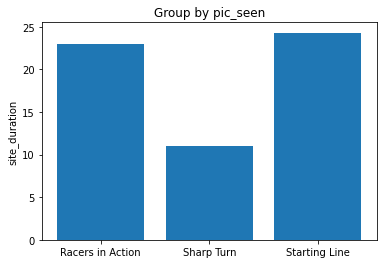

In [83]:
pic_group_du = data3.groupby("pic_seen")["site_duration"].mean()
plt.bar(["Racers in Action", "Sharp Turn", "Starting Line"], pic_group_du)
plt.ylabel('site_duration')
plt.title('Group by pic_seen')

From grouping the pic_seen, for Site_duration, Starting Line and Racers in Action are having similar performance. Sharp Turn is having the lowest value.

Text(0.5, 1.0, 'Group by pic_seen')

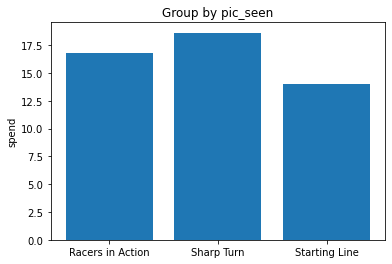

In [84]:
pic_group_du = data3.groupby("pic_seen")["spend"].mean()
plt.bar(["Racers in Action", "Sharp Turn", "Starting Line"], pic_group_du)
plt.ylabel('spend')
plt.title('Group by pic_seen')

In Spend, which is the amount of merchandise purchased, three options are having similar performances.

Text(0.5, 1.0, 'Group by pic_seen')

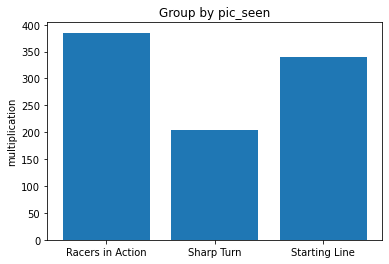

In [85]:
pic_group_du = data3.groupby("pic_seen")["site_duration"].mean() * data3.groupby("pic_seen")["spend"].mean()
plt.bar(["Racers in Action", "Sharp Turn", "Starting Line"], pic_group_du)
plt.ylabel('multiplication')
plt.title('Group by pic_seen')

Multiplying the two features above, "site_duration" and "spend", we can find that the Racers in Action is has the best performance among the three campaigns. 

### registration rate

Text(0.5, 1.0, 'Group by pic_seen')

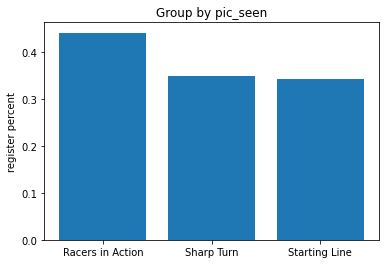

In [86]:
pic_group_du = data3.groupby("pic_seen")["register"].sum() / data3.groupby("pic_seen").count()['register']
plt.bar(["Racers in Action", "Sharp Turn", "Starting Line"], pic_group_du)
plt.ylabel('register percent')
plt.title('Group by pic_seen')

Secondly, I plot a bar chart of the register percentage for each of the three campaign options, by calculating the register divided by the number counted. From this section, we can still find that Racers in Action has the highest value.

I found that the bar plot of multiplication of site_duration feature values and spend feature values is similar to
plot of bar plot of register percent.

## Statistical

### Perform t-statistics and p-statistics for each head-to-head test:

In this section, my Null Hypothesis is to assume the there is no difference among the three pic_seen, 'Racers in Action', 'Sharp Turn', 'Starting Line'.

In [88]:
por1 = data3.loc[data3["pic_seen"]=='Racers in Action']["register"]
por2 = data3.loc[data3["pic_seen"]=='Sharp Turn']["register"]
por3 = data3.loc[data3["pic_seen"]=='Starting Line']["register"]


(t, p)= stats.ttest_ind(por1.values,por2.values, equal_var=False)
print("The t-statistics is: ", t)
print("The p-statistics is: ", p)

The t-statistics is:  4.483983175631638
The p-statistics is:  7.69613709155986e-06


In [89]:
(t, p)= stats.ttest_ind(por1.values,por3.values, equal_var=False)
print("The t-statistics is: ", t)
print("The p-statistics is: ", p)

The t-statistics is:  4.844354466304721
The p-statistics is:  1.357059422760036e-06


In [90]:
(t, p)= stats.ttest_ind(por2.values,por3.values, equal_var=False)
print("The t-statistics is: ", t)
print("The p-statistics is: ", p)

The t-statistics is:  0.3546036791692854
The p-statistics is:  0.7229192023249931


According to previous plots and p-value results, we can assume Racers in Action is the most optimal campaign. If the null hypothesis assumes that there is no significant difference between three pictures, according to the calculated t value and p value, At a significance level greater than 99 percent, we have rejected the null hypothesis (p value is too low). Hence 'Racers in Action' is indeed the best one.